# Genre classification task:

## Our goal is to create a classifier that takes book reviews and guesses the genre of the book.
### Let's first start this task doing some changes to our data, because it has a lot of noise.
#### This includes :

- Label encoding the genres
- Take out common words
- Remove punctuation and other special characters
- Remove extra whitespaces
- Convert to lowercase


In [4]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
data = pd.read_csv('goodreads_15k_english.csv')

# Drop rows where 'review_text' is null
data = data.dropna(subset=['review_text'])

# Label encode the genres
label_encoder = LabelEncoder()
data['genre_label'] = label_encoder.fit_transform(data['genres'])

# Check the result
print("\nCleaned Sample Data:")
data.head()


Cleaned Sample Data:


,review_id,book_id,review_text,rating,genres,genre_label
0,02381f5f59e402933f273eb1ed55d84e,237018,Some innovative and effective uses of form in ...,4,fiction,3
1,47daf6c5a05ba97d68c755af888f97ab,7763,"I read this book many, many, many...and did I ...",5,fiction,3
2,9a0c7f8a5ce2d5bda7c6608c241cafff,16128105,Big Brother It's hard to know what to say abou...,3,fiction,3
3,254972a8ab840e770b1c170bf98de45c,12893014,"The House at Tyneford, by Natasha Solomon, Nar...",0,fiction,3
4,8f3b23746cd1932ffce72fb2401a4d32,3235139,"Have you ever finished a book, put it down, an...",4,fiction,3


In [5]:
from collections import Counter

# Tokenize and clean text by removing punctuation and converting to lowercase
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()  # Split by whitespace
    return tokens

# Apply tokenization to all reviews
data['tokens'] = data['review_text'].apply(tokenize)

# Flatten the list of tokens to get a count of all words
all_tokens = [token for tokens in data['tokens'] for token in tokens]
token_counts = Counter(all_tokens)

# Display the 17 most common words
most_common_words = token_counts.most_common(17)
print("Most common words:", most_common_words)

Most common words: [('the', 960055), ('and', 579496), ('a', 493113), ('to', 476888), ('of', 462559), ('i', 430841), ('in', 283661), ('is', 276470), ('it', 249277), ('this', 239964), ('that', 228460), ('was', 187289), ('book', 171715), ('for', 158683), ('but', 145437), ('with', 142279), ('as', 124143)]


In [6]:
# Define a list of common words to remove (e.g., most_common_words[:17])
words_to_remove = [word for word, count in most_common_words]

# Function to filter out common words
def remove_common_words(tokens, words_to_remove):
    return [token for token in tokens if token not in words_to_remove]

# Apply function to remove common words from each tokenized review
data['filtered_tokens'] = data['tokens'].apply(lambda tokens: remove_common_words(tokens, words_to_remove))

# Optionally, join filtered tokens back to text for BERT processing
data['filtered_review_text'] = data['filtered_tokens'].apply(lambda tokens: ' '.join(tokens))

# Preview the cleaned reviews
print(data[['review_text', 'filtered_review_text']].head())

                                         review_text  \
0  Some innovative and effective uses of form in ...   
1  I read this book many, many, many...and did I ...   
2  Big Brother It's hard to know what to say abou...   
3  The House at Tyneford, by Natasha Solomon, Nar...   
4  Have you ever finished a book, put it down, an...   

                                filtered_review_text  
0  some innovative effective uses form short stor...  
1  read many many manyand did mention many moons ...  
2  big brother its hard know what say about which...  
3  house at tyneford by natasha solomon narrated ...  
4  have you ever finished put down then thought y...  


# Our first approach was using TF-IDF vectorization technique, which captures the importance of words and bigrams to train a model for genre classification

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # Using unigrams and bigrams
X = tfidf.fit_transform(data['review_text'])
y = data['genre_label']  # Assuming genres are label-encoded in 'genre_label'


## The first model used was LogisticRegression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the resampled dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression with the best parameters
best_log_reg_smote2 = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=200, random_state=42)

# Train the model
best_log_reg_smote2.fit(X_train, y_train)

# Predict on the test set
y_pred = best_log_reg_smote2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.5816

Classification Report:
               precision    recall  f1-score   support

    children       0.66      0.73      0.69      3043
      comics       0.69      0.65      0.67      2987
     fantasy       0.48      0.46      0.47      2951
     fiction       0.38      0.35      0.36      2923
     history       0.55      0.50      0.53      2967
     mystery       0.59      0.60      0.59      3000
 non-fiction       0.55      0.63      0.59      3028
      poetry       0.81      0.75      0.78      2993
     romance       0.58      0.67      0.62      2950
 young-adult       0.52      0.48      0.50      3158

    accuracy                           0.58     30000
   macro avg       0.58      0.58      0.58     30000
weighted avg       0.58      0.58      0.58     30000



## Let's now try RandomForest Classifier

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest with the specified parameters
rf_model = RandomForestClassifier(max_depth=None, min_samples_split=10, n_estimators=200, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.5073
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.66      0.62      3043
           1       0.63      0.61      0.62      2987
           2       0.40      0.36      0.38      2951
           3       0.30      0.24      0.26      2923
           4       0.50      0.43      0.46      2967
           5       0.55      0.50      0.52      3000
           6       0.41      0.60      0.48      3028
           7       0.77      0.74      0.76      2993
           8       0.48      0.61      0.53      2950
           9       0.46      0.33      0.38      3158

    accuracy                           0.51     30000
   macro avg       0.51      0.51      0.50     30000
weighted avg       0.51      0.51      0.50     30000



### The accuracy got worse compared to the LogisticRegression, let's try Naive Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Naive Bayes model with the specified alpha
nb_model = MultinomialNB(alpha=0.5)

# Train the model
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Accuracy: 0.5436
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.66      3043
           1       0.68      0.60      0.64      2987
           2       0.42      0.44      0.43      2951
           3       0.36      0.31      0.33      2923
           4       0.51      0.48      0.50      2967
           5       0.57      0.53      0.55      3000
           6       0.56      0.57      0.56      3028
           7       0.74      0.73      0.74      2993
           8       0.52      0.64      0.57      2950
           9       0.43      0.45      0.44      3158

    accuracy                           0.54     30000
   macro avg       0.54      0.54      0.54     30000
weighted avg       0.54      0.54      0.54     30000



## Let's now try XG-Boost

In [53]:
from xgboost import XGBClassifier

# Train XGBoost with reasonable parameters
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, max_depth=6, n_estimators=100)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))


/Users/rcs/anaconda3/envs/TAAC/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:23:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.5540666666666667
Classification Report:
               precision    recall  f1-score   support

    children       0.64      0.67      0.66      3043
      comics       0.61      0.66      0.63      2987
     fantasy       0.47      0.45      0.46      2951
     fiction       0.35      0.36      0.36      2923
     history       0.56      0.46      0.50      2967
     mystery       0.62      0.53      0.57      3000
 non-fiction       0.45      0.62      0.52      3028
      poetry       0.82      0.74      0.78      2993
     romance       0.55      0.62      0.58      2950
 young-adult       0.53      0.43      0.47      3158

    accuracy                           0.55     30000
   macro avg       0.56      0.55      0.55     30000
weighted avg       0.56      0.55      0.55     30000



# Results for the 4 different classification tasks using TF-IDF vectorization techniques:

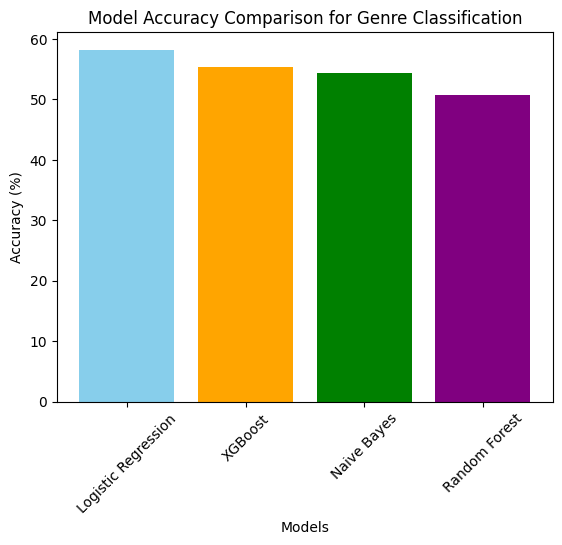

In [59]:
import matplotlib.pyplot as plt

# Accuracy values from your experimentation
model_names = ['Logistic Regression', 'XGBoost', 'Naive Bayes', 'Random Forest']
accuracies = [58.2, 55.4, 54.4, 50.7]  # Replace with actual values

plt.bar(model_names, accuracies, color=['skyblue', 'orange', 'green', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison for Genre Classification")
plt.xticks(rotation=45)
plt.show()


## Let's try using another vectorization technique, Word2Vec with the best performing model, which was LogisticRegression

In [7]:
from gensim.models import Word2Vec
import numpy as np

# Tokenize the cleaned text into words
tokenized_reviews = [text.split() for text in data['filtered_review_text']]

# Train Word2Vec model on the tokenized reviews
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=300, window=5, min_count=2, workers=4)

# Calculate average Word2Vec embeddings for each review
def get_avg_word2vec(tokens, model, vector_size):
    # Filter out words not in the vocabulary
    valid_words = [model.wv[word] for word in tokens if word in model.wv]
    if valid_words:
        return np.mean(valid_words, axis=0)
    else:
        return np.zeros(vector_size)  # return a zero vector if no valid words

# Apply function to all reviews
X_word2vec = np.array([get_avg_word2vec(review, word2vec_model, 300) for review in tokenized_reviews])
y= data["genre_label"]
# Check shape
print("Word2Vec matrix shape:", X_word2vec.shape)


Word2Vec matrix shape: (150000, 300)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=200, random_state=42)

# Train the model
model.fit(X_train, y_train)

print("Model training completed.")

Model training completed.


In [12]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.49

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.65      0.62      3043
           1       0.52      0.49      0.51      2987
           2       0.37      0.31      0.34      2951
           3       0.31      0.20      0.24      2923
           4       0.47      0.47      0.47      2967
           5       0.49      0.52      0.50      3000
           6       0.48      0.55      0.51      3028
           7       0.68      0.72      0.70      2993
           8       0.46      0.61      0.52      2950
           9       0.39      0.35      0.37      3158

    accuracy                           0.49     30000
   macro avg       0.48      0.49      0.48     30000
weighted avg       0.48      0.49      0.48     30000



## Comparing the two results between TF-IDF and Word2Vec Vectorization, we can see clearly that, for this problem, TF-IDF performed way better then the Word2vec
#### This can be because it directly emphasizes unique, genre-specific words by assigning higher weights to frequently occurring terms in each review, making it ideal for classification.
#### In contrast, Word2Vec averages word embeddings, which can dilute the importance of specific terms and lacks the high-dimensional specificity that TF-IDF provides, making it less effective for distinguishing between genres in shorter texts.

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Most important words and features for genre classification

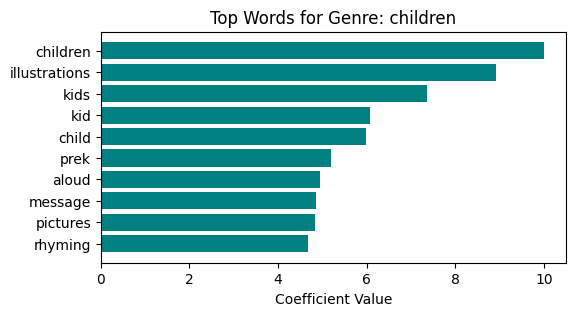

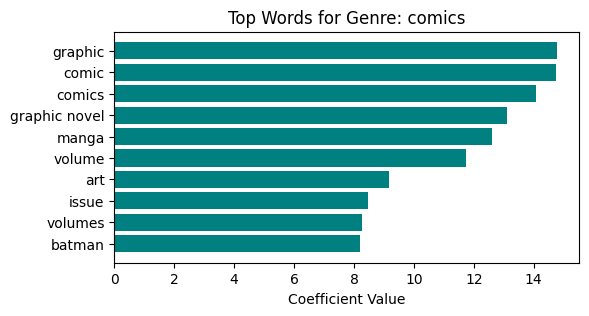

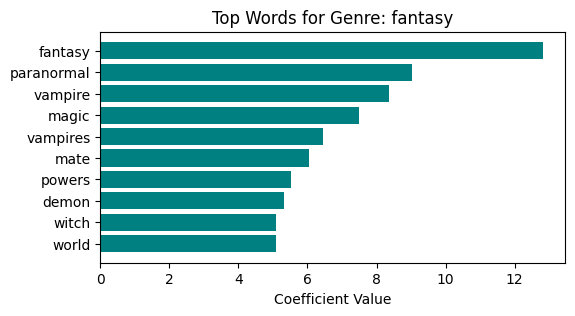

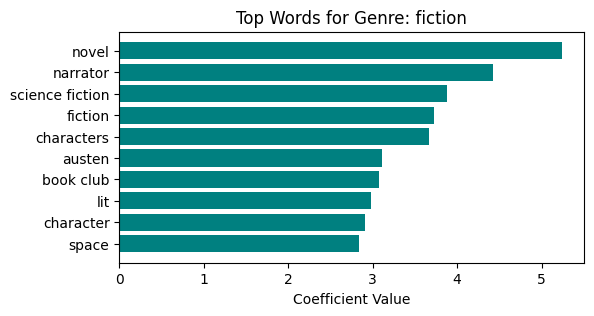

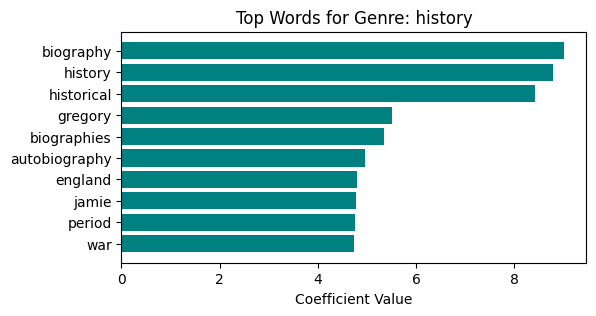

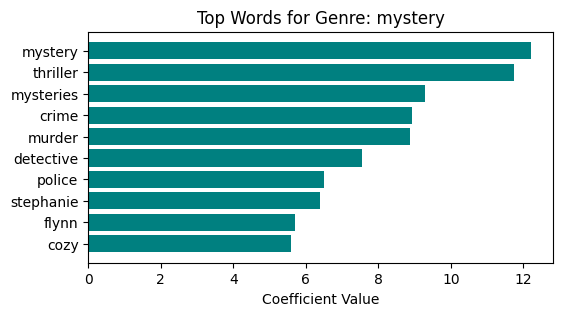

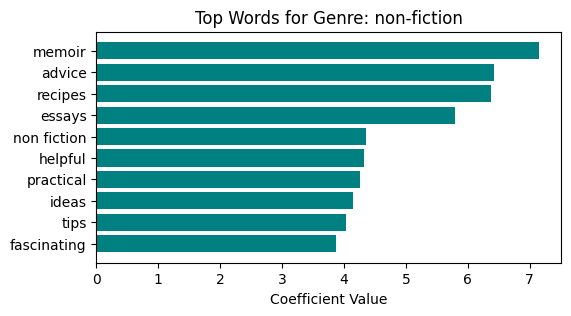

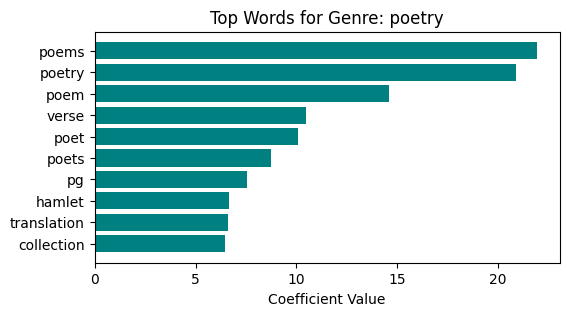

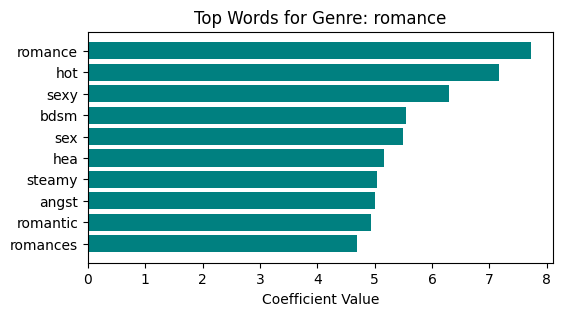

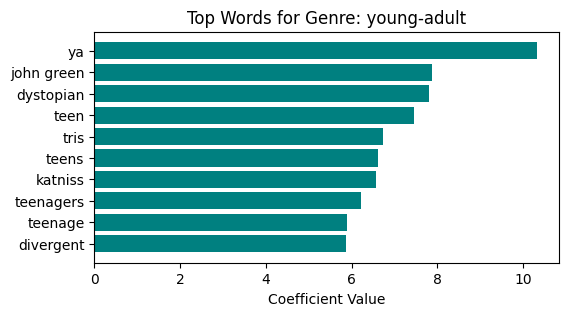

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure that `tfidf`, `log_reg`, and `label_encoder` are already defined and trained on the new dataset

# Get feature names from TF-IDF vectorizer and coefficients from the trained Logistic Regression model
feature_names = tfidf.get_feature_names_out()
coefficients = best_log_reg_smote2.coef_

# Number of top features to display
top_n = 10

# Plot the top features for each genre
for i, genre in enumerate(label_encoder.classes_):
    # Get the indices of the top N coefficients for the genre
    top_indices = np.argsort(coefficients[i])[-top_n:]
    top_features = [feature_names[j] for j in top_indices]
    top_coefficients = coefficients[i][top_indices]
    
    # Plot
    plt.figure(figsize=(6, 3))
    plt.barh(top_features, top_coefficients, color='teal')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top Words for Genre: {genre}")
    plt.show()


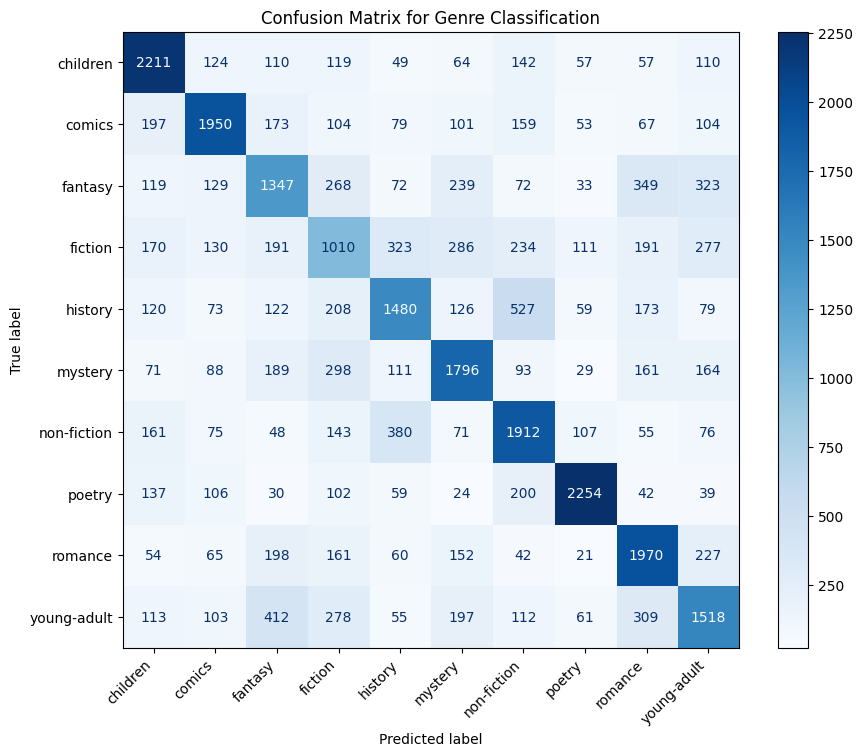

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create and customize the confusion matrix plot
fig, ax = plt.subplots(figsize=(10, 8))  # Increase figure size

# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_log_reg_smote2, X_test, y_test, display_labels=label_encoder.classes_, cmap='Blues', ax=ax
)

# Rotate x-axis labels and adjust font size
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Set title and show the plot
plt.title("Confusion Matrix for Genre Classification")
plt.show()
